## Import necessary dependencies

In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [ ]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.3
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

os.makedirs(DATA_ROOT, exist_ok=True)

Device: cuda


## Download Data - MNIST

In [ ]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True, transform=data_transforms['test']),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Check Images

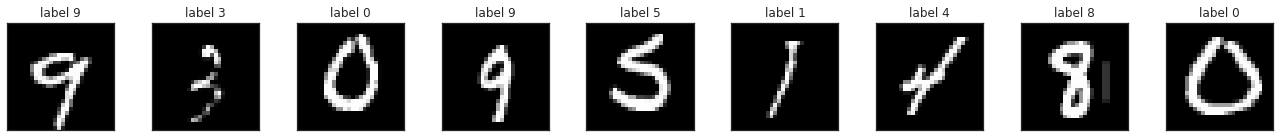

In [ ]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Model Define
- Cumbersome Model: two hidden layers with 1200 rectified linear units
- Small Model: two hidden layers with 800 rectified linear units
- Distilled Model: two hidden layers with 800 rectified linear units

### Utility Functions

In [ ]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=80)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

## Cumbersome Model

==========> Teacher model
17:30:29 --- Epoch: 1	Train loss: 0.2246	Valid loss: 0.0993	Train accuracy: 95.45	Valid accuracy: 96.77
17:30:56 --- Epoch: 3	Train loss: 0.1408	Valid loss: 0.0695	Train accuracy: 97.08	Valid accuracy: 97.74
17:31:23 --- Epoch: 5	Train loss: 0.1115	Valid loss: 0.0552	Train accuracy: 97.54	Valid accuracy: 98.21
17:31:49 --- Epoch: 7	Train loss: 0.0969	Valid loss: 0.0481	Train accuracy: 97.98	Valid accuracy: 98.57
17:32:16 --- Epoch: 9	Train loss: 0.0870	Valid loss: 0.0461	Train accuracy: 98.07	Valid accuracy: 98.59
17:32:43 --- Epoch: 11	Train loss: 0.0781	Valid loss: 0.0388	Train accuracy: 98.37	Valid accuracy: 98.77
17:33:09 --- Epoch: 13	Train loss: 0.0735	Valid loss: 0.0416	Train accuracy: 98.49	Valid accuracy: 98.71
17:33:36 --- Epoch: 15	Train loss: 0.0659	Valid loss: 0.0353	Train accuracy: 98.60	Valid accuracy: 98.84
17:34:02 --- Epoch: 17	Train loss: 0.0631	Valid loss: 0.0351	Train accuracy: 98.65	Valid accuracy: 98.81
17:34:29 --- Epoch: 19	Train loss:

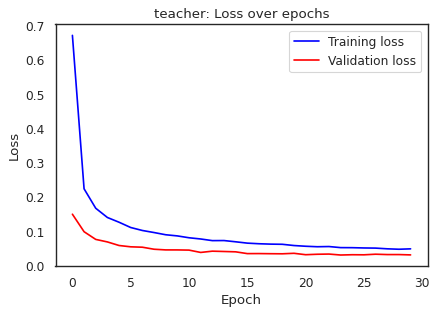


teacher model valid accuracy: 0.9899


In [ ]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.015
N_EPOCHS = 30
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, test_loader, DEVICE)
print(f"\nteacher model valid accuracy: {valid_acc:.4f}")

## Small Model
Train small model base on groud Truth

=======> Student trained on Ground Truth
17:37:11 --- Epoch: 1	Train loss: 0.1921	Valid loss: 0.1052	Train accuracy: 95.24	Valid accuracy: 96.71
17:37:37 --- Epoch: 3	Train loss: 0.1177	Valid loss: 0.0772	Train accuracy: 96.73	Valid accuracy: 97.60
17:38:04 --- Epoch: 5	Train loss: 0.0893	Valid loss: 0.0581	Train accuracy: 97.44	Valid accuracy: 98.03
17:38:30 --- Epoch: 7	Train loss: 0.0750	Valid loss: 0.0487	Train accuracy: 97.86	Valid accuracy: 98.40
17:38:57 --- Epoch: 9	Train loss: 0.0660	Valid loss: 0.0447	Train accuracy: 98.22	Valid accuracy: 98.48
17:39:23 --- Epoch: 11	Train loss: 0.0563	Valid loss: 0.0396	Train accuracy: 98.41	Valid accuracy: 98.68
17:39:50 --- Epoch: 13	Train loss: 0.0507	Valid loss: 0.0452	Train accuracy: 98.42	Valid accuracy: 98.58
17:40:16 --- Epoch: 15	Train loss: 0.0482	Valid loss: 0.0346	Train accuracy: 98.63	Valid accuracy: 98.81
17:40:43 --- Epoch: 17	Train loss: 0.0437	Valid loss: 0.0389	Train accuracy: 98.80	Valid accuracy: 98.77
17:41:09 --- Epoch:

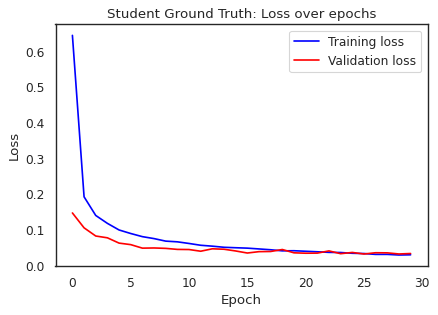


student model valid accuracy: 0.9896


In [ ]:
print(f"=======> Student trained on Ground Truth")

LEARNING_RATE = 0.015
N_EPOCHS = 30

model_s_true = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true, optimizer, _ = training_loop(model_s_true, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2)
torch.save(model_s_true.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

## Distilled Model
train distilled model with different temperatures

=======> Temperature: 0.1
=======> Teacher model trained with Temperature 0.1
17:50:44 --- Epoch: 1	Train loss: 0.2196	Valid loss: 0.0961	Train accuracy: 95.44	Valid accuracy: 97.07
17:51:11 --- Epoch: 3	Train loss: 0.1424	Valid loss: 0.0697	Train accuracy: 96.93	Valid accuracy: 97.81
17:51:37 --- Epoch: 5	Train loss: 0.1130	Valid loss: 0.0611	Train accuracy: 97.31	Valid accuracy: 98.01
17:52:04 --- Epoch: 7	Train loss: 0.0958	Valid loss: 0.0483	Train accuracy: 97.85	Valid accuracy: 98.39
17:52:31 --- Epoch: 9	Train loss: 0.0851	Valid loss: 0.0478	Train accuracy: 98.15	Valid accuracy: 98.30
17:52:58 --- Epoch: 11	Train loss: 0.0781	Valid loss: 0.0439	Train accuracy: 98.33	Valid accuracy: 98.53
17:53:25 --- Epoch: 13	Train loss: 0.0723	Valid loss: 0.0393	Train accuracy: 98.45	Valid accuracy: 98.70
17:53:52 --- Epoch: 15	Train loss: 0.0666	Valid loss: 0.0379	Train accuracy: 98.64	Valid accuracy: 98.79
17:54:19 --- Epoch: 17	Train loss: 0.0615	Valid loss: 0.0352	Train accuracy: 98.65	Vali

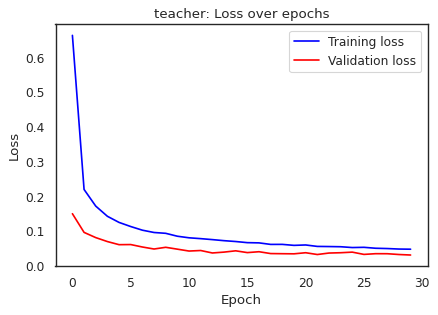

=======> Student model trained with Temperature 0.1
17:57:28 --- Epoch: 1	Train loss: 0.0981	Valid loss: 0.4616	Train accuracy: 83.82	Valid accuracy: 90.94
17:57:55 --- Epoch: 3	Train loss: 0.0461	Valid loss: 0.2306	Train accuracy: 92.03	Valid accuracy: 95.29
17:58:22 --- Epoch: 5	Train loss: 0.0303	Valid loss: 0.1655	Train accuracy: 94.45	Valid accuracy: 96.25
17:58:50 --- Epoch: 7	Train loss: 0.0237	Valid loss: 0.1242	Train accuracy: 95.42	Valid accuracy: 96.97
17:59:17 --- Epoch: 9	Train loss: 0.0199	Valid loss: 0.1055	Train accuracy: 96.08	Valid accuracy: 97.22
17:59:44 --- Epoch: 11	Train loss: 0.0175	Valid loss: 0.0936	Train accuracy: 96.62	Valid accuracy: 97.58
18:00:11 --- Epoch: 13	Train loss: 0.0156	Valid loss: 0.0880	Train accuracy: 96.75	Valid accuracy: 97.61
18:00:39 --- Epoch: 15	Train loss: 0.0142	Valid loss: 0.0794	Train accuracy: 97.06	Valid accuracy: 97.74
18:01:06 --- Epoch: 17	Train loss: 0.0130	Valid loss: 0.0723	Train accuracy: 97.23	Valid accuracy: 97.93
18:01:33

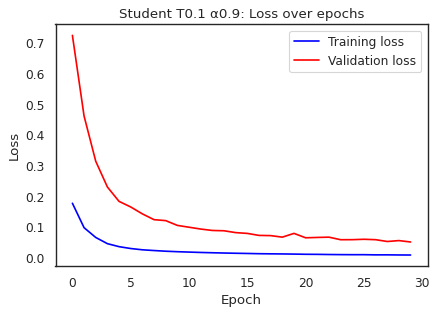


student model valid accuracy: 0.9848
=======> Temperature: 0.4
=======> Teacher model trained with Temperature 0.4
18:04:17 --- Epoch: 1	Train loss: 0.2212	Valid loss: 0.0992	Train accuracy: 95.63	Valid accuracy: 96.79
18:04:44 --- Epoch: 3	Train loss: 0.1417	Valid loss: 0.0668	Train accuracy: 97.07	Valid accuracy: 97.99
18:05:10 --- Epoch: 5	Train loss: 0.1110	Valid loss: 0.0535	Train accuracy: 97.60	Valid accuracy: 98.22
18:05:36 --- Epoch: 7	Train loss: 0.0958	Valid loss: 0.0496	Train accuracy: 97.94	Valid accuracy: 98.43
18:06:03 --- Epoch: 9	Train loss: 0.0889	Valid loss: 0.0453	Train accuracy: 98.14	Valid accuracy: 98.50
18:06:29 --- Epoch: 11	Train loss: 0.0791	Valid loss: 0.0456	Train accuracy: 98.27	Valid accuracy: 98.45
18:06:55 --- Epoch: 13	Train loss: 0.0724	Valid loss: 0.0422	Train accuracy: 98.43	Valid accuracy: 98.59
18:07:22 --- Epoch: 15	Train loss: 0.0687	Valid loss: 0.0404	Train accuracy: 98.51	Valid accuracy: 98.81
18:07:48 --- Epoch: 17	Train loss: 0.0639	Valid l

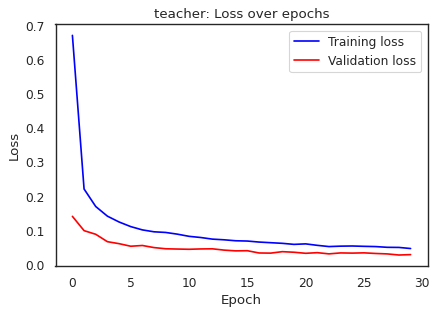

=======> Student model trained with Temperature 0.4
18:10:55 --- Epoch: 1	Train loss: 0.0913	Valid loss: 0.2791	Train accuracy: 92.79	Valid accuracy: 95.19
18:11:22 --- Epoch: 3	Train loss: 0.0452	Valid loss: 0.1575	Train accuracy: 95.39	Valid accuracy: 96.66
18:11:49 --- Epoch: 5	Train loss: 0.0333	Valid loss: 0.1266	Train accuracy: 96.15	Valid accuracy: 97.24
18:12:17 --- Epoch: 7	Train loss: 0.0274	Valid loss: 0.0942	Train accuracy: 96.81	Valid accuracy: 97.72
18:12:44 --- Epoch: 9	Train loss: 0.0228	Valid loss: 0.0877	Train accuracy: 97.08	Valid accuracy: 97.92
18:13:11 --- Epoch: 11	Train loss: 0.0201	Valid loss: 0.0771	Train accuracy: 97.29	Valid accuracy: 98.08
18:13:39 --- Epoch: 13	Train loss: 0.0173	Valid loss: 0.0655	Train accuracy: 97.80	Valid accuracy: 98.37
18:14:06 --- Epoch: 15	Train loss: 0.0163	Valid loss: 0.0636	Train accuracy: 97.85	Valid accuracy: 98.39
18:14:33 --- Epoch: 17	Train loss: 0.0145	Valid loss: 0.0617	Train accuracy: 97.95	Valid accuracy: 98.36
18:15:01

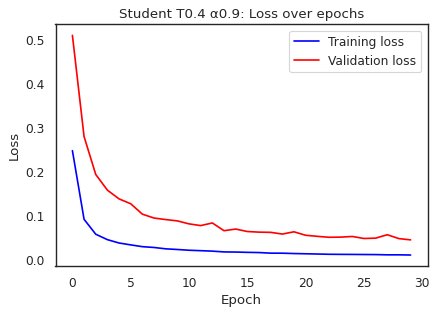


student model valid accuracy: 0.9880
=======> Temperature: 0.7000000000000001
=======> Teacher model trained with Temperature 0.7000000000000001
18:17:45 --- Epoch: 1	Train loss: 0.2202	Valid loss: 0.0975	Train accuracy: 95.45	Valid accuracy: 96.91
18:18:11 --- Epoch: 3	Train loss: 0.1403	Valid loss: 0.0749	Train accuracy: 96.77	Valid accuracy: 97.57
18:18:38 --- Epoch: 5	Train loss: 0.1124	Valid loss: 0.0575	Train accuracy: 97.60	Valid accuracy: 98.07
18:19:04 --- Epoch: 7	Train loss: 0.0958	Valid loss: 0.0497	Train accuracy: 97.80	Valid accuracy: 98.49
18:19:30 --- Epoch: 9	Train loss: 0.0843	Valid loss: 0.0442	Train accuracy: 98.17	Valid accuracy: 98.51
18:19:56 --- Epoch: 11	Train loss: 0.0783	Valid loss: 0.0419	Train accuracy: 98.36	Valid accuracy: 98.72
18:20:23 --- Epoch: 13	Train loss: 0.0720	Valid loss: 0.0384	Train accuracy: 98.52	Valid accuracy: 98.68
18:20:49 --- Epoch: 15	Train loss: 0.0682	Valid loss: 0.0358	Train accuracy: 98.62	Valid accuracy: 98.85
18:21:16 --- Epoch:

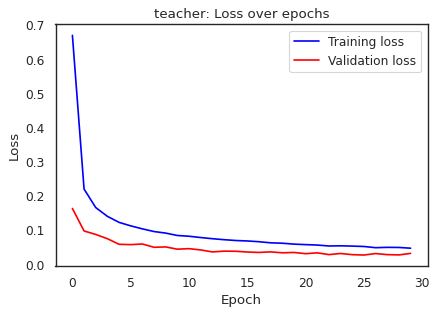

=======> Student model trained with Temperature 0.7000000000000001
18:24:22 --- Epoch: 1	Train loss: 0.1097	Valid loss: 0.1451	Train accuracy: 94.76	Valid accuracy: 96.59
18:24:49 --- Epoch: 3	Train loss: 0.0566	Valid loss: 0.0948	Train accuracy: 96.52	Valid accuracy: 97.48
18:25:16 --- Epoch: 5	Train loss: 0.0402	Valid loss: 0.0750	Train accuracy: 97.17	Valid accuracy: 98.01
18:25:43 --- Epoch: 7	Train loss: 0.0325	Valid loss: 0.0667	Train accuracy: 97.53	Valid accuracy: 98.15
18:26:10 --- Epoch: 9	Train loss: 0.0257	Valid loss: 0.0541	Train accuracy: 97.97	Valid accuracy: 98.48
18:26:37 --- Epoch: 11	Train loss: 0.0218	Valid loss: 0.0571	Train accuracy: 98.03	Valid accuracy: 98.44
18:27:04 --- Epoch: 13	Train loss: 0.0196	Valid loss: 0.0481	Train accuracy: 98.12	Valid accuracy: 98.47
18:27:32 --- Epoch: 15	Train loss: 0.0175	Valid loss: 0.0442	Train accuracy: 98.39	Valid accuracy: 98.73
18:27:59 --- Epoch: 17	Train loss: 0.0159	Valid loss: 0.0430	Train accuracy: 98.44	Valid accuracy:

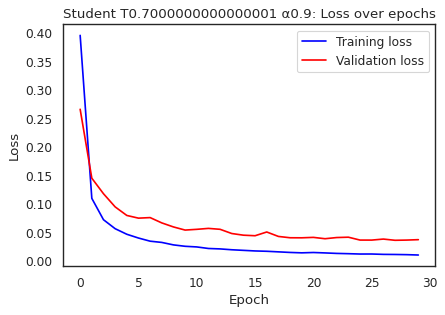


student model valid accuracy: 0.9893
=======> Temperature: 1.0000000000000002
=======> Teacher model trained with Temperature 1.0000000000000002
18:31:08 --- Epoch: 1	Train loss: 0.2229	Valid loss: 0.1102	Train accuracy: 95.21	Valid accuracy: 96.69
18:31:34 --- Epoch: 3	Train loss: 0.1426	Valid loss: 0.0658	Train accuracy: 96.96	Valid accuracy: 97.91
18:32:01 --- Epoch: 5	Train loss: 0.1134	Valid loss: 0.0578	Train accuracy: 97.52	Valid accuracy: 98.09
18:32:27 --- Epoch: 7	Train loss: 0.0939	Valid loss: 0.0571	Train accuracy: 97.80	Valid accuracy: 98.18
18:32:53 --- Epoch: 9	Train loss: 0.0867	Valid loss: 0.0451	Train accuracy: 98.16	Valid accuracy: 98.61
18:33:20 --- Epoch: 11	Train loss: 0.0771	Valid loss: 0.0419	Train accuracy: 98.36	Valid accuracy: 98.54
18:33:46 --- Epoch: 13	Train loss: 0.0725	Valid loss: 0.0395	Train accuracy: 98.54	Valid accuracy: 98.63
18:34:12 --- Epoch: 15	Train loss: 0.0683	Valid loss: 0.0361	Train accuracy: 98.61	Valid accuracy: 98.73
18:34:39 --- Epoch:

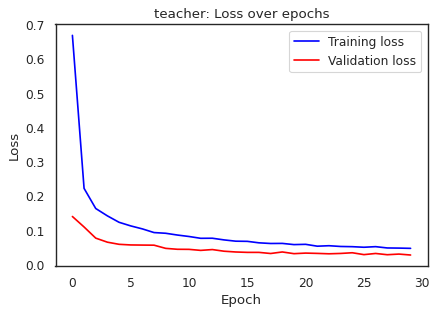

=======> Student model trained with Temperature 1.0000000000000002
18:37:44 --- Epoch: 1	Train loss: 0.1465	Valid loss: 0.1163	Train accuracy: 95.35	Valid accuracy: 96.45
18:38:11 --- Epoch: 3	Train loss: 0.0709	Valid loss: 0.0648	Train accuracy: 97.08	Valid accuracy: 97.98
18:38:38 --- Epoch: 5	Train loss: 0.0488	Valid loss: 0.0618	Train accuracy: 97.21	Valid accuracy: 98.13
18:39:05 --- Epoch: 7	Train loss: 0.0376	Valid loss: 0.0500	Train accuracy: 97.91	Valid accuracy: 98.23
18:39:33 --- Epoch: 9	Train loss: 0.0304	Valid loss: 0.0444	Train accuracy: 98.09	Valid accuracy: 98.55
18:40:00 --- Epoch: 11	Train loss: 0.0253	Valid loss: 0.0441	Train accuracy: 98.19	Valid accuracy: 98.50
18:40:27 --- Epoch: 13	Train loss: 0.0223	Valid loss: 0.0392	Train accuracy: 98.42	Valid accuracy: 98.75
18:40:54 --- Epoch: 15	Train loss: 0.0193	Valid loss: 0.0365	Train accuracy: 98.54	Valid accuracy: 98.83
18:41:21 --- Epoch: 17	Train loss: 0.0174	Valid loss: 0.0336	Train accuracy: 98.69	Valid accuracy:

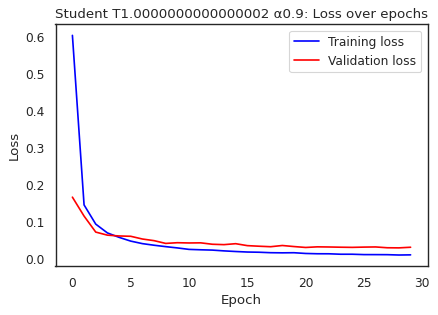


student model valid accuracy: 0.9892


In [ ]:
# Train
LEARNING_RATE_T = 0.015
LEARNING_RATE_S = 0.015
N_EPOCHS = 30
ALPHA = 0.9

for T in np.arange(0.1, 1.2, 0.3):
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")


=======> Temperature: 30
=======> Teacher model trained with Temperature 30
18:44:32 --- Epoch: 1	Train loss: 0.2239	Valid loss: 0.1031	Train accuracy: 95.40	Valid accuracy: 96.85
18:44:58 --- Epoch: 3	Train loss: 0.1424	Valid loss: 0.0661	Train accuracy: 97.09	Valid accuracy: 97.97
18:45:24 --- Epoch: 5	Train loss: 0.1114	Valid loss: 0.0540	Train accuracy: 97.47	Valid accuracy: 98.32
18:45:51 --- Epoch: 7	Train loss: 0.0980	Valid loss: 0.0587	Train accuracy: 97.74	Valid accuracy: 98.07
18:46:17 --- Epoch: 9	Train loss: 0.0857	Valid loss: 0.0445	Train accuracy: 98.06	Valid accuracy: 98.60
18:46:44 --- Epoch: 11	Train loss: 0.0767	Valid loss: 0.0403	Train accuracy: 98.34	Valid accuracy: 98.72
18:47:10 --- Epoch: 13	Train loss: 0.0717	Valid loss: 0.0410	Train accuracy: 98.45	Valid accuracy: 98.58
18:47:37 --- Epoch: 15	Train loss: 0.0668	Valid loss: 0.0361	Train accuracy: 98.51	Valid accuracy: 98.84
18:48:03 --- Epoch: 17	Train loss: 0.0624	Valid loss: 0.0369	Train accuracy: 98.67	Valid 

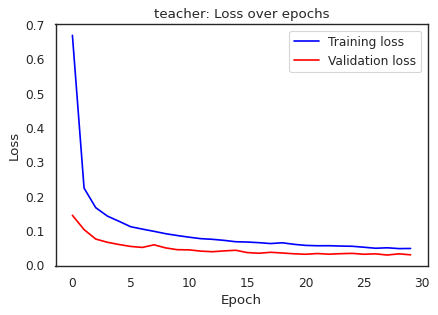

=======> Student model trained with Temperature 30
18:51:09 --- Epoch: 1	Train loss: 0.3336	Valid loss: 0.0419	Train accuracy: 98.01	Valid accuracy: 98.61
18:51:37 --- Epoch: 3	Train loss: 0.1838	Valid loss: 0.0365	Train accuracy: 98.38	Valid accuracy: 98.82
18:52:04 --- Epoch: 5	Train loss: 0.1432	Valid loss: 0.0357	Train accuracy: 98.52	Valid accuracy: 98.80
18:52:31 --- Epoch: 7	Train loss: 0.1218	Valid loss: 0.0337	Train accuracy: 98.64	Valid accuracy: 98.88
18:52:58 --- Epoch: 9	Train loss: 0.1090	Valid loss: 0.0329	Train accuracy: 98.70	Valid accuracy: 98.92
18:53:25 --- Epoch: 11	Train loss: 0.0996	Valid loss: 0.0329	Train accuracy: 98.73	Valid accuracy: 98.90
18:53:52 --- Epoch: 13	Train loss: 0.0929	Valid loss: 0.0325	Train accuracy: 98.75	Valid accuracy: 98.92
18:54:19 --- Epoch: 15	Train loss: 0.0874	Valid loss: 0.0332	Train accuracy: 98.77	Valid accuracy: 98.92
18:54:46 --- Epoch: 17	Train loss: 0.0824	Valid loss: 0.0325	Train accuracy: 98.85	Valid accuracy: 98.88
18:55:13 

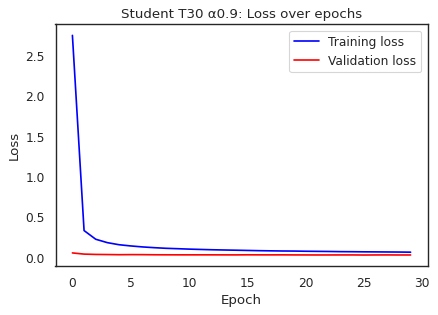


student model valid accuracy: 0.9898
=======> Temperature: 50
=======> Teacher model trained with Temperature 50
18:57:56 --- Epoch: 1	Train loss: 0.2206	Valid loss: 0.0950	Train accuracy: 95.80	Valid accuracy: 97.09
18:58:22 --- Epoch: 3	Train loss: 0.1390	Valid loss: 0.0739	Train accuracy: 96.80	Valid accuracy: 97.59
18:58:48 --- Epoch: 5	Train loss: 0.1131	Valid loss: 0.0567	Train accuracy: 97.51	Valid accuracy: 98.10
18:59:14 --- Epoch: 7	Train loss: 0.0976	Valid loss: 0.0549	Train accuracy: 97.79	Valid accuracy: 98.19
18:59:41 --- Epoch: 9	Train loss: 0.0879	Valid loss: 0.0443	Train accuracy: 98.25	Valid accuracy: 98.70
19:00:07 --- Epoch: 11	Train loss: 0.0805	Valid loss: 0.0393	Train accuracy: 98.44	Valid accuracy: 98.78
19:00:33 --- Epoch: 13	Train loss: 0.0732	Valid loss: 0.0388	Train accuracy: 98.50	Valid accuracy: 98.84
19:01:00 --- Epoch: 15	Train loss: 0.0675	Valid loss: 0.0364	Train accuracy: 98.56	Valid accuracy: 98.81
19:01:26 --- Epoch: 17	Train loss: 0.0627	Valid los

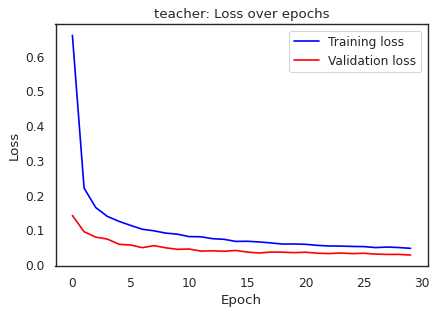

=======> Student model trained with Temperature 50
19:04:32 --- Epoch: 1	Train loss: 0.3268	Valid loss: 0.0453	Train accuracy: 97.89	Valid accuracy: 98.49
19:04:59 --- Epoch: 3	Train loss: 0.1763	Valid loss: 0.0367	Train accuracy: 98.41	Valid accuracy: 98.76
19:05:26 --- Epoch: 5	Train loss: 0.1372	Valid loss: 0.0338	Train accuracy: 98.61	Valid accuracy: 98.89
19:05:53 --- Epoch: 7	Train loss: 0.1175	Valid loss: 0.0332	Train accuracy: 98.65	Valid accuracy: 98.91
19:06:20 --- Epoch: 9	Train loss: 0.1054	Valid loss: 0.0315	Train accuracy: 98.72	Valid accuracy: 98.92
19:06:47 --- Epoch: 11	Train loss: 0.0965	Valid loss: 0.0308	Train accuracy: 98.72	Valid accuracy: 99.02
19:07:14 --- Epoch: 13	Train loss: 0.0894	Valid loss: 0.0300	Train accuracy: 98.83	Valid accuracy: 99.03
19:07:41 --- Epoch: 15	Train loss: 0.0851	Valid loss: 0.0297	Train accuracy: 98.84	Valid accuracy: 99.00
19:08:08 --- Epoch: 17	Train loss: 0.0803	Valid loss: 0.0297	Train accuracy: 98.83	Valid accuracy: 99.00
19:08:36 

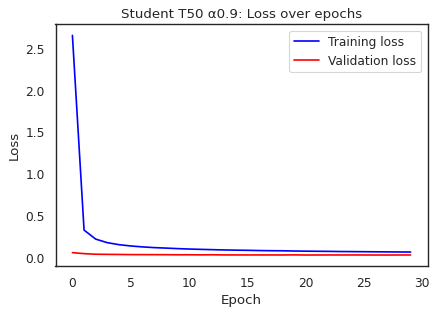


student model valid accuracy: 0.9899
=======> Temperature: 70
=======> Teacher model trained with Temperature 70
19:11:19 --- Epoch: 1	Train loss: 0.2204	Valid loss: 0.0905	Train accuracy: 95.61	Valid accuracy: 97.12
19:11:45 --- Epoch: 3	Train loss: 0.1400	Valid loss: 0.0661	Train accuracy: 97.04	Valid accuracy: 97.88
19:12:12 --- Epoch: 5	Train loss: 0.1124	Valid loss: 0.0599	Train accuracy: 97.51	Valid accuracy: 98.05
19:12:38 --- Epoch: 7	Train loss: 0.0967	Valid loss: 0.0523	Train accuracy: 97.78	Valid accuracy: 98.21
19:13:04 --- Epoch: 9	Train loss: 0.0865	Valid loss: 0.0441	Train accuracy: 98.16	Valid accuracy: 98.61
19:13:31 --- Epoch: 11	Train loss: 0.0775	Valid loss: 0.0430	Train accuracy: 98.31	Valid accuracy: 98.69
19:13:57 --- Epoch: 13	Train loss: 0.0714	Valid loss: 0.0385	Train accuracy: 98.47	Valid accuracy: 98.77
19:14:23 --- Epoch: 15	Train loss: 0.0678	Valid loss: 0.0394	Train accuracy: 98.44	Valid accuracy: 98.61
19:14:49 --- Epoch: 17	Train loss: 0.0641	Valid los

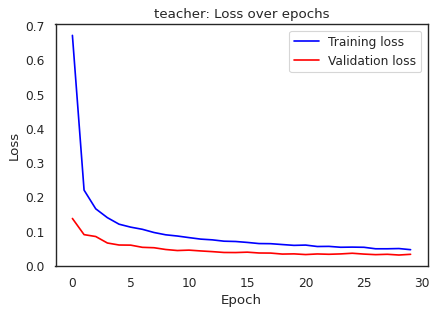

=======> Student model trained with Temperature 70
19:17:54 --- Epoch: 1	Train loss: 0.3235	Valid loss: 0.0459	Train accuracy: 98.12	Valid accuracy: 98.54
19:18:21 --- Epoch: 3	Train loss: 0.1778	Valid loss: 0.0395	Train accuracy: 98.46	Valid accuracy: 98.67
19:18:48 --- Epoch: 5	Train loss: 0.1385	Valid loss: 0.0382	Train accuracy: 98.60	Valid accuracy: 98.74
19:19:15 --- Epoch: 7	Train loss: 0.1180	Valid loss: 0.0366	Train accuracy: 98.66	Valid accuracy: 98.76
19:19:42 --- Epoch: 9	Train loss: 0.1054	Valid loss: 0.0362	Train accuracy: 98.80	Valid accuracy: 98.78
19:20:09 --- Epoch: 11	Train loss: 0.0964	Valid loss: 0.0349	Train accuracy: 98.77	Valid accuracy: 98.84
19:20:36 --- Epoch: 13	Train loss: 0.0904	Valid loss: 0.0353	Train accuracy: 98.86	Valid accuracy: 98.80
19:21:03 --- Epoch: 15	Train loss: 0.0843	Valid loss: 0.0346	Train accuracy: 98.85	Valid accuracy: 98.86
19:21:30 --- Epoch: 17	Train loss: 0.0800	Valid loss: 0.0349	Train accuracy: 98.91	Valid accuracy: 98.88
19:21:57 

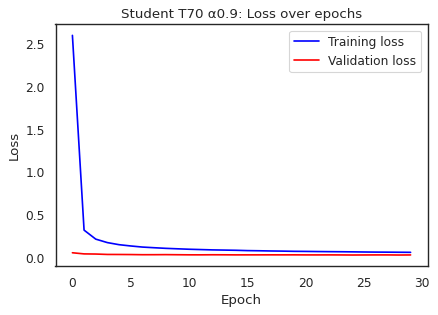


student model valid accuracy: 0.9887
=======> Temperature: 90
=======> Teacher model trained with Temperature 90
19:24:40 --- Epoch: 1	Train loss: 0.2209	Valid loss: 0.1072	Train accuracy: 95.49	Valid accuracy: 96.56
19:25:06 --- Epoch: 3	Train loss: 0.1410	Valid loss: 0.0694	Train accuracy: 96.97	Valid accuracy: 97.85
19:25:33 --- Epoch: 5	Train loss: 0.1102	Valid loss: 0.0659	Train accuracy: 97.39	Valid accuracy: 97.83
19:25:59 --- Epoch: 7	Train loss: 0.0968	Valid loss: 0.0505	Train accuracy: 97.93	Valid accuracy: 98.28
19:26:25 --- Epoch: 9	Train loss: 0.0854	Valid loss: 0.0434	Train accuracy: 98.07	Valid accuracy: 98.67
19:26:52 --- Epoch: 11	Train loss: 0.0764	Valid loss: 0.0404	Train accuracy: 98.37	Valid accuracy: 98.64
19:27:18 --- Epoch: 13	Train loss: 0.0700	Valid loss: 0.0394	Train accuracy: 98.48	Valid accuracy: 98.70
19:27:44 --- Epoch: 15	Train loss: 0.0682	Valid loss: 0.0366	Train accuracy: 98.55	Valid accuracy: 98.83
19:28:11 --- Epoch: 17	Train loss: 0.0627	Valid los

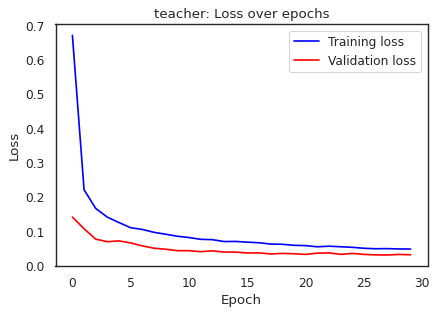

=======> Student model trained with Temperature 90
19:31:17 --- Epoch: 1	Train loss: 0.3125	Valid loss: 0.0466	Train accuracy: 98.01	Valid accuracy: 98.51
19:31:44 --- Epoch: 3	Train loss: 0.1710	Valid loss: 0.0415	Train accuracy: 98.42	Valid accuracy: 98.58
19:32:12 --- Epoch: 5	Train loss: 0.1334	Valid loss: 0.0385	Train accuracy: 98.58	Valid accuracy: 98.72
19:32:39 --- Epoch: 7	Train loss: 0.1135	Valid loss: 0.0365	Train accuracy: 98.67	Valid accuracy: 98.79
19:33:06 --- Epoch: 9	Train loss: 0.1028	Valid loss: 0.0359	Train accuracy: 98.70	Valid accuracy: 98.84
19:33:33 --- Epoch: 11	Train loss: 0.0934	Valid loss: 0.0345	Train accuracy: 98.78	Valid accuracy: 98.88
19:34:01 --- Epoch: 13	Train loss: 0.0875	Valid loss: 0.0351	Train accuracy: 98.83	Valid accuracy: 98.77
19:34:28 --- Epoch: 15	Train loss: 0.0810	Valid loss: 0.0342	Train accuracy: 98.87	Valid accuracy: 98.91
19:34:55 --- Epoch: 17	Train loss: 0.0779	Valid loss: 0.0340	Train accuracy: 98.91	Valid accuracy: 98.90
19:35:22 

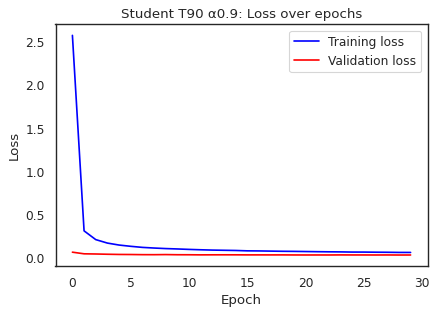


student model valid accuracy: 0.9887


In [ ]:
# Train
LEARNING_RATE_T = 0.015
LEARNING_RATE_S = 0.015
N_EPOCHS = 30
ALPHA = 0.9

for T in range(30, 110, 20):
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")
